# **Perfume Clustering & Recommendation System**

## **Project Overview**
This project aims to analyze perfumes based on their scent profiles, identify common themes among them, and build a recommendation system. By clustering perfumes based on their notes, we can uncover patterns in fragrance compositions and suggest similar perfumes based on given sample of perfume.  

## **Objectives**
1. **Identify Common Themes in Perfumes**  
   - Use Natural Language Processing (NLP) techniques to analyze fragrance descriptions.  
   - Group perfumes into meaningful clusters based on their dominant notes.  

2. **Develop a Perfume Recommendation System**  
   - Apply machine learning techniques to find similarities between perfumes.  
   - Suggest alternative perfumes based on scent similarity.  

## **Dataset Source**
- **Title:** Perfume Recommendation Dataset  
- **Source:** [Kaggle - Perfume Recommendation Dataset](https://www.kaggle.com/datasets/nandini1999/perfume-recommendation-dataset)  
- **Attributes:**
  - `Name` - Name of the perfume  
  - `Brand` - Brand of the perfume  
  - `Description` - Text description of the perfume  
  - `Notes` - Fragrance notes present in the perfume  
  - `Image URL` - URL of the perfume image  

## **Approach**
1. **Data Preprocessing**
   - Load the dataset and handle missing values.
   - Convert text data to lowercase for uniformity.
   - Remove unnecessary columns (`Description`, `Image URL`).
   - Tokenize and clean `notes` by filtering only relevant fragrance terms.

2. **Feature Engineering**
   - Convert fragrance notes into a space-separated string.
   - Use **TF-IDF Vectorization** to transform text into numerical features.

3. **Clustering Analysis**
   - Determine the optimal number of clusters using **Silhouette Score**.
   - Apply **K-Means clustering** to group perfumes with similar scent compositions.
   - Assign cluster labels to each perfume.

4. **Model Export & Storage**
   - Save the trained TF-IDF vectorizer and K-Means model using **Joblib**.
   - Store model metadata with a standardized naming convention.

5. **Visualization**
   - Reduce dimensionality using **TruncatedSVD** for better visualization.
   - Plot perfume clusters in a 2D space.

6. **Cluster Analysis & Interpretation**
   - Identify top fragrance notes in each cluster.
   - Categorize clusters into broader fragrance families.

7. **Perfume Recommendation System**
   - Implement a **cosine similarity-based** recommendation system.
   - Match user input with the closest perfume names using **fuzzy string matching**.
   - Recommend perfumes based on cluster membership and scent similarity.


---



## Importing Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from difflib import get_close_matches
from datetime import datetime
import joblib
import os

In [81]:
df = pd.read_csv('../data/raw/final_perfume_data.csv', encoding='ISO-8859-1')
df.head()

,Name,Brand,Description,Notes,Image URL
0,Tihota Eau de Parfum,Indult,"Rapa Nui for sugar, Tihota is, quite simply, ...","Vanilla bean, musks",https://static.luckyscent.com/images/products/...
1,Sola Parfum,Di Ser,A tribute to the expanse of space extending f...,"Lavender, Yuzu, Lemongrass, Magnolia, Geraniu...",https://static.luckyscent.com/images/products/...
2,Kagiroi Parfum,Di Ser,An aromatic ode to the ancient beauty of Japa...,"Green yuzu, green shikuwasa, sansho seed, cor...",https://static.luckyscent.com/images/products/...
3,Velvet Fantasy Eau de Parfum,Montale,Velvet Fantasy is a solar fragrance where cit...,"tangerine, pink pepper, black coffee, leat...",https://static.luckyscent.com/images/products/...
4,A Blvd. Called Sunset Eau de Parfum,A Lab on Fire,There's no way A Lab On Fire could relocate t...,"Bergamot, almond, violet, jasmine, leather, s...",https://static.luckyscent.com/images/products/...


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         2191 non-null   object
 1   Brand        2191 non-null   object
 2   Description  2191 non-null   object
 3   Notes        2111 non-null   object
 4   Image URL    2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB


## Data Preprocessing

In [83]:
# Creating a new df for cleaning
cleaned_df = df.copy()

In [84]:
# Removing null values from the dataset
print(cleaned_df.isnull().sum())
cleaned_df.dropna(inplace=True)

Name            0
Brand           0
Description     0
Notes          80
Image URL       0
dtype: int64


In [85]:
# Removing the column for description and imageurl
cleaned_df.drop(columns=['Description', 'Image URL'], inplace=True)

In [86]:
# Lowering the column names and the values of the column
cleaned_df.columns = cleaned_df.columns.str.lower()
cleaned_df['name'] = cleaned_df['name'].str.lower()
cleaned_df['brand'] = cleaned_df['brand'].str.lower()
cleaned_df['notes'] = cleaned_df['notes'].str.lower()


In [87]:
# Removing the duplicate rows from the dataset
print(cleaned_df.duplicated().sum())

0


In [88]:
# Spliting the note values
cleaned_df['notes'] = cleaned_df['notes'].apply(lambda x: [note.strip() for note in x.split(',')])

In [89]:
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,"[vanilla bean, musks]"
1,sola parfum,di ser,"[lavender, yuzu, lemongrass, magnolia, geraniu..."
2,kagiroi parfum,di ser,"[green yuzu, green shikuwasa, sansho seed, cor..."
3,velvet fantasy eau de parfum,montale,"[tangerine, pink pepper, black coffee, leather..."
4,a blvd. called sunset eau de parfum,a lab on fire,"[bergamot, almond, violet, jasmine, leather, s..."


In [90]:
# Extract all notes into a single list
all_notes = [note for notes_list in cleaned_df['notes'] for note in notes_list]

# Get unique notes
unique_notes = set(all_notes)

# Print unique notes
for note in unique_notes:
    print(note)


african musk
silver fir
waterlilly
tropical flowers
gin accord
animalic notes
doum palm
bleu cedar
ban timmur pepper
menthol honey gumdrops
dry pine
haitian vetivergrand cru 10%
red seaweed
oakmoss absolute and styrax balm.
grilled cigarettes
smoky incense
cumin seeds.
extract of bulgarian rose
palm leaves
creamy
maple
haitian vetiver
marine pine
blood orange (brown extraction & sfuma torchio extraction)
mandora
daisy
petitgrain (bitter orange)
espresso
blackcurrant (cassis)
jonquil
crystalized flower parts
peach aldehyde
haitian vetiver.
marigold
butter cream
sweet orris butter
suede accord
birch leaves
patchouli indonesia
elemi oil
white moss
verbena
cipriol
fleur de sel accord (vetiver oil fraction
mandarin petitgrain
irone
myrrh oil
bourbon vanilla
indonesian patchouly
bergamot from italy
quince chutney
raspberry flowers
wood click here for ingredients ãclose jasmin rouge by tom ford private blend ingredients please be aware that ingredient lists may change or vary from time t

In [91]:
# Load the curated list of notes
with open("../data/cleaned_perfume_notes.txt", "r") as file:
    curated_notes = set(file.read().splitlines())

# Filter the notes in the dataframe
cleaned_df['notes'] = cleaned_df['notes'].apply(lambda notes_list: [note for note in notes_list if note in curated_notes])

# Display the cleaned dataframe
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,[musks]
1,sola parfum,di ser,"[lavender, yuzu, lemongrass, magnolia, geraniu..."
2,kagiroi parfum,di ser,"[coriander, shiso, rosewood, vetiver, hinoki, ..."
3,velvet fantasy eau de parfum,montale,"[tangerine, leather, violet, jasmine, vanilla,..."
4,a blvd. called sunset eau de parfum,a lab on fire,"[bergamot, almond, violet, jasmine, leather, s..."


In [92]:
# Convert list of notes to space-separated string
cleaned_df["notes"] = cleaned_df["notes"].apply(lambda x: " ".join(x))

In [93]:
cleaned_df.head()

,name,brand,notes
0,tihota eau de parfum,indult,musks
1,sola parfum,di ser,lavender yuzu lemongrass magnolia geranium jas...
2,kagiroi parfum,di ser,coriander shiso rosewood vetiver hinoki cyprio...
3,velvet fantasy eau de parfum,montale,tangerine leather violet jasmine vanilla amber...
4,a blvd. called sunset eau de parfum,a lab on fire,bergamot almond violet jasmine leather sandalw...


## Model Training

### Transforming Notes to TF-IDF

In [94]:
# Apply TF-IDF
vectorizer = TfidfVectorizer()
X_notes = vectorizer.fit_transform(cleaned_df["notes"])

# Convert TF-IDF matrix to DataFrame
df_X_notes = pd.DataFrame(X_notes.toarray(), columns=vectorizer.get_feature_names_out(), index=cleaned_df["name"])

In [95]:
df_X_notes.head()

,absinth,absinthe,acacia,accord,agardwood,agarwood,agave,akigala,akigalawood,aldehyde,...,willow,wine,wisteria,wood,woods,woody,wool,wormwood,ylang,yuzu
name,,,,,,,,,,,,,,,,,,,,,
tihota eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
sola parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.42154
kagiroi parfum,0.0,0.0,0.0,0.0,0.0,0.36114,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
velvet fantasy eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
a blvd. called sunset eau de parfum,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


### Using elbow method to find the optimal cluster count

In [96]:
silhouette_scores = []
k_range = range(2, 15)

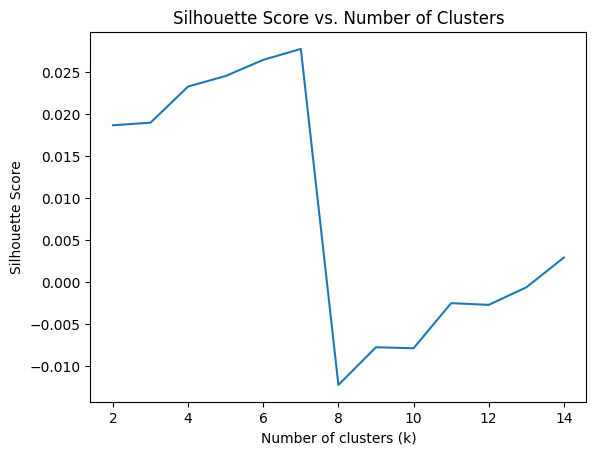

In [97]:
for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_notes)
        score = silhouette_score(X_notes, labels)
        silhouette_scores.append(score)

optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette_score = round(np.max(silhouette_scores), 2)

plt.plot(k_range, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.show()

In [98]:
# Train final model
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
final_kmeans.fit(X_notes)

KMeans(n_clusters=7, random_state=42)

In [ ]:
# Exporting the model
# NAME: model_kmeans_k{clusters}_metric{score}_date{YYYYMMDD}.pkl

MODEL_DIR = "../models/"
current_date = datetime.now().strftime("%Y%m%d")
model_path = os.path.join(MODEL_DIR, f"model_kmeans_k{optimal_k}_metric{max_silhouette_score}_date{current_date}.pkl")

model_data = {
        'vectorizer': vectorizer,
        'kmeans': final_kmeans,
        'X_notes': X_notes,
        'optimal_k': optimal_k
    }

joblib.dump(model_data, model_path)

['../models/rod\\model_kmeans_k7_metric0.03_date20250217.pkl']

In [100]:
# Reduced dimension visualization using TruncatedSVD & Plotting
def visualization_clusters(model_data, n_components=2):
    # Convert sparse matrix to dense matrix
    X_notes_dense = model_data['X_notes'].toarray()
    
    # Apply TruncatedSVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_notes_dense)
    
    plotting_clusters(X_svd, cleaned_df['cluster'])

# Subfunction plotting clusters
def plotting_clusters(X_reduced, labels):    
    """Visualize clusters in 2D space."""
    df_plot = pd.DataFrame(X_reduced, columns=['Dim1', 'Dim2'])
    df_plot['cluster'] = labels
    
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=df_plot, x='Dim1', y='Dim2', hue='cluster', 
                    palette='viridis', s=60, alpha=0.8)
    plt.title("Perfume Clusters Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [101]:
# To give overview notes of each cluster
def get_cluster_terms(vectorizer, kmeans, n_terms=10):
    """Display top terms for each cluster."""
    terms = vectorizer.get_feature_names_out()
    for cluster_id in range(kmeans.n_clusters):
        centroid = kmeans.cluster_centers_[cluster_id]
        top_terms = terms[np.argsort(centroid)[-n_terms:][::-1]]
        print(f"Cluster {cluster_id} Top Terms: {', '.join(top_terms)}")

In [106]:
def recommend_perfumes(df, model_data, perfume_name, num_recs=5):
    """
    Get perfume recommendations based on scent similarity.
    
    Args:
        df: Preprocessed DataFrame
        model_data: Trained model artifacts
        perfume_name: Input perfume name
        num_recs: Number of recommendations to return
    
    Returns:
        DataFrame with recommendations or error message
    """
    # Normalize input
    perfume_name = perfume_name.lower().strip()
    
    # Fuzzy name matching
    if perfume_name not in df['name'].values:
        matches = get_close_matches(perfume_name, df['name'], n=1)
        if not matches:
            return f"No perfume found matching '{perfume_name}'"
        perfume_name = matches[0]
        print(f"Did you mean: '{perfume_name}'?")
    
    # Get perfume data
    perfume_data = df[df['name'] == perfume_name]
    if perfume_data.empty:
        return f"Perfume '{perfume_name}' not found in database"
    
    idx = perfume_data.index[0]  # Get the index of the perfume
    if idx >= model_data['X_notes'].shape[0]:
        return f"Index {idx} is out of range for the TF-IDF matrix."
    
    cluster = model_data['kmeans'].labels_[idx]
    
    # Get cluster members
    cluster_mask = (model_data['kmeans'].labels_ == cluster)
    cluster_df = df[cluster_mask].copy()
    cluster_df = cluster_df[cluster_df['name'] != perfume_name]
    
    if cluster_df.empty:
        return f"No similar perfumes found in cluster {cluster}"
    
    # Calculate similarities
    similarities = cosine_similarity(
        model_data['X_notes'][idx].reshape(1, -1),  # Reshape for single sample
        model_data['X_notes'][cluster_df.index]
    ).flatten()
    
    # Prepare results
    results = cluster_df.assign(Similarity=similarities)
    results = results.sort_values('Similarity', ascending=False)
    
    # Return top N with similarity scores
    print(f"Top {num_recs} recommendations for '{perfume_name}':")
    return results[['name', 'brand', 'notes', 'Similarity']].head(num_recs)

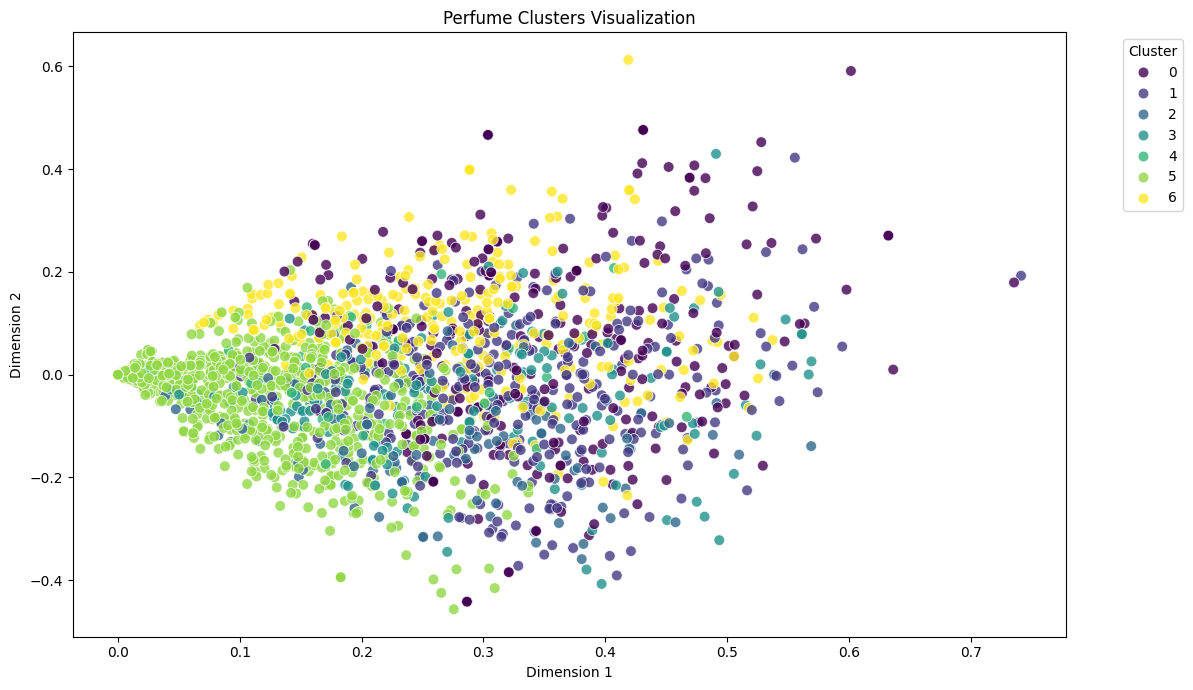

Cluster 0 Top Terms: musk, amber, bergamot, rose, jasmine, sandalwood, lemon, cedar, vanilla, violet
Cluster 1 Top Terms: patchouli, saffron, rose, sandalwood, oud, amber, cedar, cinnamon, leather, cardamom
Cluster 2 Top Terms: cedarwood, vetiver, bergamot, musk, patchouli, sandalwood, nutmeg, cardamom, lemon, grapefruit
Cluster 3 Top Terms: incense, patchouli, amber, bergamot, musk, leather, cedar, sandalwood, vetiver, vanilla
Cluster 4 Top Terms: peony, musk, vanilla, lychee, bergamot, sandalwood, rose, violet, peach, freesia
Cluster 5 Top Terms: vetiver, bergamot, jasmine, sandalwood, cedar, musk, lemon, iris, rose, oakmoss
Cluster 6 Top Terms: vanilla, sandalwood, jasmine, bergamot, patchouli, cedar, musk, violet, rose, tuberose
Top 5 recommendations for 'ormonde man eau de parfum':


,name,brand,notes,Similarity
1071,ormonde woman eau de parfum,ormonde jayne,cardamom coriander violet jasmine vetiver ceda...,0.614985
697,no. 9 bukhoor elixir de parfum,thomas kosmala,agarwood amber musk,0.543691
931,wood infusion perfume concentrate,goldfield & banks,agarwood lavender musk amber,0.464692
192,rose oud eau de parfum,alexandre. j,rose agarwood musk amber lemon,0.443543
1302,super cedar eau de parfum,byredo,rose cedar musk vetiver,0.435138


In [107]:
cleaned_df['cluster'] = model_data['kmeans'].labels_

visualization_clusters(model_data, n_components=2)

get_cluster_terms(model_data['vectorizer'], model_data['kmeans'], n_terms=10)

cleaned_df.reset_index(drop=True, inplace=True)

recommend_perfumes(cleaned_df, model_data, "ormonde man eau de parfum")

# **Cluster Analysis & Interpretation**

## **Cluster Interpretations:**
### **Cluster 0: Fresh & Floral Woody Musk**  
- **Dominant Notes:** Musk, Amber, Bergamot, Rose, Jasmine, Sandalwood  
- **Likely Represents:** Soft, warm, and slightly powdery scents with a floral-woody balance.  

### **Cluster 1: Oriental & Spicy Woody**  
- **Dominant Notes:** Patchouli, Saffron, Oud, Amber, Leather, Cardamom  
- **Likely Represents:** Deep, rich, and exotic fragrances, often found in Middle Eastern perfumery.  

### **Cluster 2: Earthy & Citrus Woody**  
- **Dominant Notes:** Cedarwood, Vetiver, Bergamot, Nutmeg, Grapefruit  
- **Likely Represents:** Fresh, woody, and slightly spicy colognes, often masculine and grounding.  

### **Cluster 3: Smoky & Resinous Oriental**  
- **Dominant Notes:** Incense, Patchouli, Amber, Leather, Vetiver, Vanilla  
- **Likely Represents:** Dark, resinous, smoky fragrances, ideal for colder seasons.  

### **Cluster 4: Fruity Floral Musk**  
- **Dominant Notes:** Peony, Lychee, Musk, Vanilla, Rose, Freesia  
- **Likely Represents:** Playful, sweet, and airy fragrances, often in feminine scents.  

### **Cluster 5: Classic Green & Woody Floral**  
- **Dominant Notes:** Vetiver, Jasmine, Cedar, Oakmoss, Lemon, Iris  
- **Likely Represents:** Earthy, natural, and vintage-style perfumes with chypre elements.  

### **Cluster 6: Creamy Floral & Sweet Woody**  
- **Dominant Notes:** Vanilla, Sandalwood, Jasmine, Patchouli, Tuberose  
- **Likely Represents:** Smooth, sweet, and seductive scents with floral-woody warmth.  

---

## **Possible Grouping into Fragrance Families**
### **1. Fresh & Woody:**  
Clusters **0, 2, 5**  
- Emphasizing citrus, green, and earthy wood tones.  

### **2. Warm & Oriental:**  
Clusters **1, 3, 6**  
- Focused on spicy, resinous, and deep woody scents.  

### **3. Floral & Sweet:**  
Clusters **4, 6**  
- Leaning toward fruity, musky, and gourmand florals.  

---

